# Trian Test Split (70 - 15 - 15)

In [216]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, mean_squared_error, r2_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [217]:
data = pd.read_csv('model_data.csv')
games = pd.read_csv('data/games.csv')

In [218]:
data = pd.merge(data, games.loc[:, ['gameId', 'homeTeamAbbr', 'visitorTeamAbbr']], on = 'gameId', how ='left')

In [219]:
data.loc[data['down'].isin([3, 4]), 'critical_down'] = 1.0
data['critical_down'] = data['critical_down'].fillna(0.0)

In [220]:
#data.loc[data['possessionTeam'] == data['homeTeamAbbr'], 'score_diff'] = data['preSnapHomeScore'] - data['preSnapVisitorScore'] 
#data.loc[data['possessionTeam'] == data['visitorTeamAbbr'], 'score_diff'] = data['preSnapVisitorScore'] - data['preSnapHomeScore'] 
#data['binned_score_diff'] = pd.qcut(data['score_diff'], q=8)

In [221]:
data['avg_yards_to_go'] = data['yardsToGo']/(4-data['down'].clip(upper=3))
data.loc[data['avg_yards_to_go'] > 5, 'long_distance'] = 1.0
data['long_distance'] = data['long_distance'].fillna(0.0)

In [202]:
data.groupby('long_distance')['causedPressure'].agg(['mean', 'count'])

,mean,count
long_distance,,
0.0,0.308749,7349
1.0,0.417260,2387


In [239]:
data.groupby(['critical_down'])['causedPressure'].agg(['mean', 'count'])

,mean,count
critical_down,,
0.0,0.298897,6892
1.0,0.423699,2844


In [ ]:
#data.groupby('binned_score_diff')['causedPressure'].agg(['mean', 'count'])

KeyError: 'binned_score_diff'

In [ ]:
#data.loc[data['score_diff'] >= 14, 'big_score_diff'] = 1.0
#data['big_score_diff'] = data['big_score_diff'].fillna(0.0)

In [224]:
# Feature 1: offenseFormation
data['offenseFormation'].value_counts()
off_formation_mapping = {'SHOTGUN':1, 'SINGLEBACK':0, 'EMPTY':1, 'I_FORM':0, 'PISTOL':0,
                         'JUMBO':0, 'WILDCAT':1}

data['is_shotgun'] = data['offenseFormation'].map(off_formation_mapping)


In [225]:
data.groupby('is_shotgun')['causedPressure'].agg(['mean', 'count'])

,mean,count
is_shotgun,,
0.0,0.338553,1852
1.0,0.335581,7861


In [226]:
data = data.loc[:, ['causedPressure', 'critical_down', 'long_distance']]

In [227]:
# Replace 'target' with the actual column name of your target variable
X = data.drop(columns=['causedPressure'])  # Features
y = data['causedPressure']  # Target variable

# Step 1: Split into train and temp (70-30 split)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Step 2: Split temp into validation and test (50-50 split of the remaining 30%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


train = pd.concat([X_train, y_train], axis=1)
# Step 1: Count the number of rows where causedPressure is 1
count_pressure_1 = train[train['causedPressure'] == 1].shape[0]
print(f"Number of rows where causedPressure is 1: {count_pressure_1}")

count_pressure_0 = train[train['causedPressure'] == 0].shape[0]
print(f"Number of rows where causedPressure is 0: {count_pressure_0}")

# Step 2: Randomly sample the same number of rows where causedPressure is 0
sampled_pressure_0 = train[train['causedPressure'] == 0].sample(n=count_pressure_1, random_state=42)

# Step 3: Get all rows where causedPressure is 1
pressure_1 = train[train['causedPressure'] == 1]

# Step 4: Concatenate the sampled rows with the rows where causedPressure is 1
balanced_final_df = pd.concat([sampled_pressure_0, pressure_1])

X_train = balanced_final_df.drop('causedPressure', axis=1)
y_train = balanced_final_df['causedPressure']

# Print the sizes of each dataset
print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])


Number of rows where causedPressure is 1: 2285
Number of rows where causedPressure is 0: 4530
Training set size: 4570
Validation set size: 1460
Test set size: 1461


In [228]:
# Print the percentage of positive examples in the y_train, y_val, and y_test
print("Percentage of positive examples in y_train:", y_train.mean())
print("Percentage of positive examples in y_val:", y_val.mean())
print("Percentage of positive examples in y_test:", y_test.mean())

Percentage of positive examples in y_train: 0.5
Percentage of positive examples in y_val: 0.3356164383561644
Percentage of positive examples in y_test: 0.3353867214236824


# Baseline Model

Validation Metrics:
Mean Absolute Error (MAE): 0.3863
Mean Squared Error (MSE): 0.3863
R² Score: -0.7325

Test Metrics:
Mean Absolute Error (MAE): 0.3669
Mean Squared Error (MSE): 0.3669
R² Score: -0.6459

Sample Predictions:
      Actual  Predicted
5324       0          0
6679       0          0
3394       1          0
8162       1          0
4752       0          0
Test Accuracy: 0.6331
Confusion Matrix:
[[737 234]
 [302 188]]


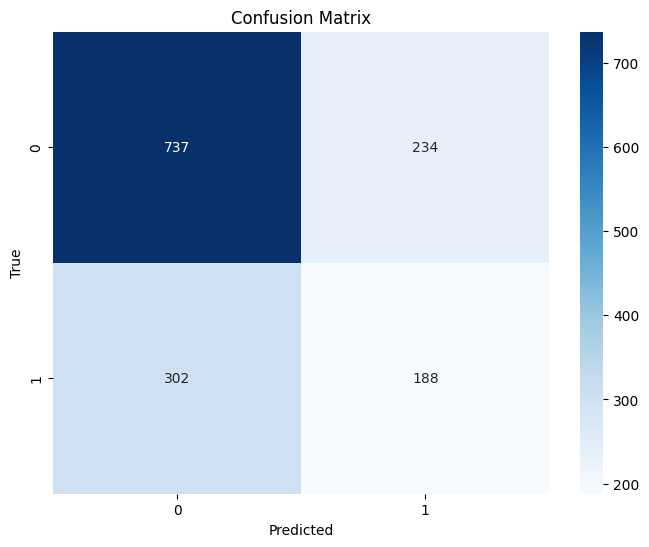

In [188]:
# Initialize and train the Linear Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on validation and test sets
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Evaluate the model on the validation set
print("Validation Metrics:")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_val, y_val_pred):.4f}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_val, y_val_pred):.4f}")
print(f"R² Score: {r2_score(y_val, y_val_pred):.4f}")

# Evaluate the model on the test set
print("\nTest Metrics:")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_test_pred):.4f}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_test_pred):.4f}")
print(f"R² Score: {r2_score(y_test, y_test_pred):.4f}")

# Optional: Compare actual vs predicted values on the test set
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})
print("\nSample Predictions:")
print(results.head())

# Calculate accuracy
accuracy = accuracy_score(y_test, y_test_pred.round())
print(f"Test Accuracy: {accuracy:.4f}")

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_test_pred.round())

# Print the raw confusion matrix
print("Confusion Matrix:")
print(cm)

# Optional: Visualize the confusion matrix with a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [229]:
model_weights = pd.DataFrame(index = X.columns)

In [230]:
model_weights['odds_multiplier'] = np.exp(model.coef_).reshape(-1)

In [231]:
model_weights

,odds_multiplier
critical_down,1.579833
long_distance,1.255816


# XGBoost model

In [232]:
# 5. Create and train the XGBoost model
#    - We use early stopping on the validation set to avoid overfitting.
model = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',  # As of xgboost > 1.3, you should specify eval_metric
    early_stopping_rounds=10

)

model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

# 6. Evaluate the model on the test set
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# 7. Print a classification report for detailed metrics
print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred))

[0]	validation_0-logloss:0.68942
[1]	validation_0-logloss:0.68788
[2]	validation_0-logloss:0.68735
[3]	validation_0-logloss:0.68727
[4]	validation_0-logloss:0.68736
[5]	validation_0-logloss:0.68750
[6]	validation_0-logloss:0.68763
[7]	validation_0-logloss:0.68775
[8]	validation_0-logloss:0.68784
[9]	validation_0-logloss:0.68791
[10]	validation_0-logloss:0.68796
[11]	validation_0-logloss:0.68800
[12]	validation_0-logloss:0.68803
[13]	validation_0-logloss:0.68804


Test Accuracy: 0.6331
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.71      0.76      0.73       971
           1       0.45      0.38      0.41       490

    accuracy                           0.63      1461
   macro avg       0.58      0.57      0.57      1461
weighted avg       0.62      0.63      0.63      1461



c:\Users\johng\Documents\Data Science Competition team\big-data-bowl\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:22:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [238]:
y_pred_train = model.predict(X_train)
accuracy_score(y_pred_train, y_train)

0.5586433260393873

Confusion Matrix:
[[737 234]
 [302 188]]


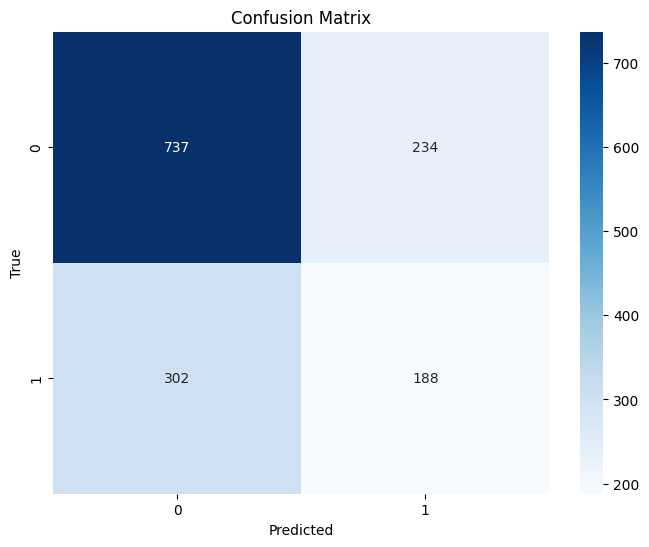

In [149]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the raw confusion matrix
print("Confusion Matrix:")
print(cm)

# Optional: Visualize the confusion matrix with a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [148]:
accuracy_score(y_test, y_pred)

0.6331279945242985

# Hyperparamater Tuning

In [38]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import numpy as np

# 1. Define a parameter grid for XGBoost hyperparameters
param_dist = {
    "n_estimators": [50, 100, 200, 300],
    "max_depth": [3, 4, 5, 6],
    "learning_rate": [0.1, 0.01, 0.001],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 3, 5],
    "gamma": [0, 0.1, 0.3, 0.5],
    "reg_alpha": [0, 0.01, 0.1, 1],
    "reg_lambda": [0, 0.01, 0.1, 1]
}

# 2. Initialize an XGBoost classifier
xgb_clf = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# 3. Instantiate the RandomizedSearchCV
#    n_iter: number of random parameter settings to try
#    cv: number of folds in cross-validation
#    scoring: metric used for selection
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=20,                  # Adjust to your preference
    scoring='accuracy',         # Could be 'f1', 'roc_auc', etc. depending on the problem
    cv=3,                       # K-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1                   # Use all available cores
)

# 4. Fit the RandomizedSearchCV on your training set
random_search.fit(X_train, y_train)

# 5. Check best parameters and score
print("Best parameters found: ", random_search.best_params_)
print("Best CV accuracy: ", random_search.best_score_)

# 6. Use the best_estimator_ to predict on validation/test set
best_model = random_search.best_estimator_

# If you have a separate validation set
y_val_pred = best_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy with tuned model: {val_accuracy:.4f}")

# 7. Evaluate on test set
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy with tuned model: {test_accuracy:.4f}")

print("Classification Report on Test Set:")
print(classification_report(y_test, y_test_pred))

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Print the raw confusion matrix
print("Confusion Matrix:")
print(cm)

# Optional: Visualize the confusion matrix with a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


c:\Users\johng\Documents\Data Science Competition team\big-data-bowl\venv\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'